# Исходные данные

**Задание 1.**
Выберите датасет, который имеет отношение к вашей области интересов или исследований. Датасет должен содержать неструктурированные данные, требующие разметки для решения конкретной задачи, например, анализа настроений или распознавания именованных сущностей.

В качестве датасета для выполнения домашнего задания выбран следующий датасет:
https://www.kaggle.com/datasets/datafiniti/hotel-reviews/data. <br>
Данный набор данных содержит: список из 1000 отелей и отзывов о них, предоставленный бизнес-базой данных Datafiniti, который включает местоположение отеля, название, рейтинг, данные отзывов, название, имя пользователя и многое другое.

In [73]:
# Импорт необходимых библиотек
import pandas as pd
from sklearn.model_selection import train_test_split # для разделения данных на обучающую и тестовую выборку
from sklearn.feature_extraction.text import TfidfVectorizer # для преобразования текста в вектор
from sklearn.linear_model import LogisticRegression # использование модели логистической регрессии
from sklearn.metrics import accuracy_score, classification_report # оценка производительности модели
from sklearn.pipeline import Pipeline # конвеер обработки данных
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [74]:
# Загружаем данные
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data_collection_markup/7282_1.csv', sep=',')
df.head(5)

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


# Первичный анализ данных

In [75]:
# Переименуем столбцы для удобной работы с данными
df = df.rename(index=str, columns={'reviews.date':'reviewsdate', 'reviews.dateAdded':'reviewsdateAdded',
       'reviews.doRecommend':'reviewsdoRecommend', 'reviews.id':'reviewsid', 'reviews.rating':'reviewsrating', 'reviews.text':'reviewstext',
       'reviews.title':'reviewstitle', 'reviews.userCity':'reviewsuserCity', 'reviews.username':'reviewsusername',
       'reviews.userProvince':'reviewsuserProvince'})

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35912 entries, 0 to 35911
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   address              35912 non-null  object 
 1   categories           35912 non-null  object 
 2   city                 35912 non-null  object 
 3   country              35912 non-null  object 
 4   latitude             35826 non-null  float64
 5   longitude            35826 non-null  float64
 6   name                 35912 non-null  object 
 7   postalCode           35857 non-null  object 
 8   province             35912 non-null  object 
 9   reviewsdate          35653 non-null  object 
 10  reviewsdateAdded     35912 non-null  object 
 11  reviewsdoRecommend   0 non-null      float64
 12  reviewsid            0 non-null      float64
 13  reviewsrating        35050 non-null  float64
 14  reviewstext          35888 non-null  object 
 15  reviewstitle         34286 non-null  obje

In [77]:
# Размерность датасета
df.shape

(35912, 19)

In [78]:
# Проверка отсутствующих значений
pd.isna(df).sum()[pd.isna(df).sum() > 0]

latitude                  86
longitude                 86
postalCode                55
reviewsdate              259
reviewsdoRecommend     35912
reviewsid              35912
reviewsrating            862
reviewstext               24
reviewstitle            1626
reviewsuserCity        19649
reviewsusername           43
reviewsuserProvince    18394
dtype: int64

In [79]:
# Удалим столбцы reviewsdoRecommend и reviewsid, т.к пропущенные значения составляют 100 %
df.drop(columns=['reviewsdoRecommend', 'reviewsid'], inplace=True)

In [80]:
# Удаление строк с рейтингом равным нулю:
df = df[df['reviewsrating'] > 0]

In [81]:
# Удаление строк с рейтингом выше 5
df = df[df['reviewsrating'] <= 5]

In [82]:
# Преобразование значений рейтинга в целые числа
df.reviewsrating = df.reviewsrating.astype(int)

# Замена отсутствующих значений

In [83]:
# Для столбца reviewstext заполненим пропущенные значения в текстовых отзывах значением 'x'
df.reviewstext = df.reviewstext.fillna('x')

In [84]:
# Для столбца reviewstitle заполненим пропущенные значения в названии заголовка отзыва значением 'no_title'
df.reviewstitle = df.reviewstitle.fillna('no_title')

In [85]:
# Для столбцов (latitude - широта, longitude-долгота)
# заменим отсутствующие значения на 0:
df['latitude'] = df['latitude'].fillna(0)
df['longitude'] = df['longitude'].fillna(0)

In [86]:
# Для следующихстолбцов заменим отсутствующие значения на NaN (Not a Number)
# для обозначения отсутствующих или некорректных данных в числовых столбцах:
df['postalCode'] = df['postalCode'].fillna('NaN')
df['reviewsdate'] = df['reviewsdate'].fillna('NaN')
df['reviewsuserCity'] = df['reviewsuserCity'].fillna('NaN')
df['reviewsusername'] = df['reviewsusername'].fillna('NaN')
df['reviewsuserProvince'] = df['reviewsuserProvince'].fillna('NaN')

In [89]:
# Проверка отсутствующих значений, после внесения изменений
pd.isna(df).sum()[pd.isna(df).sum() > 0]

Series([], dtype: int64)

In [87]:
# Сводная статистика по датасету
df.describe()

,latitude,longitude,reviewsrating
count,34356.000000,34356.000000,34356.000000
mean,37.181804,-85.696124,3.759518
std,7.211802,33.000011,1.276880
min,-25.436750,-166.559040,1.000000
25%,33.796738,-104.981704,3.000000
50%,37.933273,-86.868140,4.000000
75%,41.657447,-77.178510,5.000000
max,63.877674,115.164407,5.000000


**Задание 2.**
Выполните разметку на основе правил (rule-based labeling) на подмножестве выбранного датасета. Разработайте и реализуйте набор правил или условий, которые позволят автоматически присваивать метки данным на основе определенных шаблонов или критериев.


In [90]:
# Выполним разметку и создадим список с отзывом и рейтингом
df = df[['reviewstext','reviewsrating']]. copy ()
df[df['reviewsrating'] < 4]
df

,reviewstext,reviewsrating
0,Pleasant 10 min walk along the sea front to th...,4
1,Really lovely hotel. Stayed on the very top fl...,5
2,Ett mycket bra hotell. Det som drog ner betyge...,5
3,We stayed here for four nights in October. The...,5
4,We stayed here for four nights in October. The...,5
...,...,...
35905,We truly enjoyed staying at the Elk Springs re...,5
35906,We were here for a 2nd time the last weekend o...,5
35907,Best of the Best!!!! My family and I stayed in...,5
35908,Amazing Vacation in Beautiful Cabin We stayed ...,5


<Axes: >

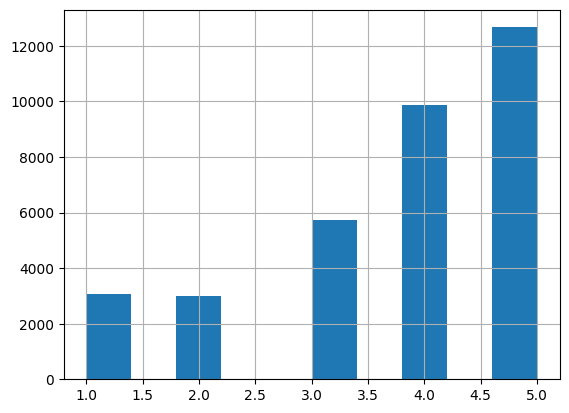

In [91]:
# Распределение значений рейтинга
df["reviewsrating"].hist()

In [96]:
# Создадим функцию (правило) для создания бинарных меток на основе рейтингов.
# Если рейтинг больше 3, функция возвращает 1.
# Если рейтинг меньше или равен 3, функция возвращает 0.
def rule_rating(row):
    if row['reviewsrating'] > 3:
        return  1
    elif row['reviewsrating'] <= 3:
        return  0

In [97]:
df['rating_label'] = df.apply(rule_rating, axis=1)

<Axes: >

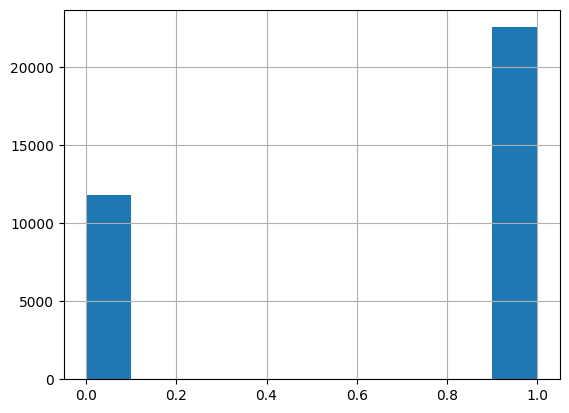

In [98]:
df['rating_label'].hist()

In [100]:
df = df[df['reviewsrating'].notnull()]
df

,reviewstext,reviewsrating,rating_label
0,Pleasant 10 min walk along the sea front to th...,4,1
1,Really lovely hotel. Stayed on the very top fl...,5,1
2,Ett mycket bra hotell. Det som drog ner betyge...,5,1
3,We stayed here for four nights in October. The...,5,1
4,We stayed here for four nights in October. The...,5,1
...,...,...,...
35905,We truly enjoyed staying at the Elk Springs re...,5,1
35906,We were here for a 2nd time the last weekend o...,5,1
35907,Best of the Best!!!! My family and I stayed in...,5,1
35908,Amazing Vacation in Beautiful Cabin We stayed ...,5,1


**Задача 3.**
Выполните разметку вручную отдельного подмножества выбранного датасета с помощью выбранного вами инструмента разметки.

In [102]:
# Разобьем набор данных df на две части: размеченные и неразмеченные отзывы
from sklearn.model_selection import train_test_split
labeled_reviews, unlabeled_reviews = train_test_split(df, train_size=0.5, random_state=56)

In [103]:
# Создадим функцию для обучения модели
def train_model(labaled_data):
    vect = TfidfVectorizer()
    x = vect.fit_transform(labaled_data['reviewstext'])
    y = labaled_data['rating_label']
    model = LogisticRegression()
    model.fit(x,y)
    return model, vect

In [104]:
# Выполним обучение начальной модели на тренировочных данных
model, vect = train_model(labeled_reviews)

In [106]:
# Используем модель для прогнозирования меток для немаркированных данных
x_unlabeled = vect.transform(unlabeled_reviews['reviewstext'])
y_unlabeled_predicted = model.predict(x_unlabeled)

In [108]:
# Вычислим энтропию предсказаний
y_unlabeled_proba = model.predict_proba(x_unlabeled)
uncertainly = -(y_unlabeled_proba * np.log2(y_unlabeled_proba)).sum(axis=1)
uncertainly

array([0.33637081, 0.73799664, 0.99608494, ..., 0.75082372, 0.86112348,
       0.32258329])

In [110]:
# Выбираем 100 отзывов с наименьшей неопределенностью для ручной разметки, где
# labeled_reviews_new содержит 100 отзывов, которые модель считает наименее неопределенными
# и они использются для ручной разметки, так как они более "уверенны", а
# unlabeled_reviews_new содержит оставшиеся отзывы, которые имеют большую неопределенность и
# данные отзывы могут быть оставлены для дальнейшего анализа
labeled_reviews_new = unlabeled_reviews.iloc[uncertainly.argsort()[:100]]
unlabeled_reviews_new = unlabeled_reviews.iloc[uncertainly.argsort()[100:]]

In [112]:
labeled_reviews_new

,reviewstext,reviewsrating,rating_label
24884,"Great, great, great!! The staff was wonderful!...",5,1
2808,"Was a great stay, nice and clean and quiet",5,1
30650,Loved this hotel perfect the paring was great ...,4,1
30591,Great room. Clean and very comfortable. Great ...,5,1
14669,"Clean, comfortable, quiet. Very friendly staff...",4,1
...,...,...,...
11084,A great place to stay as your driving through ...,4,1
24108,Great stay love it,5,1
25424,Excellent location. Very clean and comfortable...,5,1
28940,"It was a great hotel, excellent location, and ...",5,1


**Задача 4.**
Объедините данные, размеченные вручную, с данными, размеченными на основе правил. Объедините два подмножества размеченных данных в один набор данных, сохранив при этом соответствующую структуру и целостность.

In [121]:
labeled_reviews = pd.concat([labeled_reviews, labeled_reviews_new])
labeled_reviews

,reviewstext,reviewsrating,rating_label
25275,Clean looking room but my girlfriend still wok...,4,1
22424,I would highly recommend anyone visiting to Ca...,5,1
30501,"It's more like a 40 dollar a night room , but ...",4,1
3609,I was only able to enjoy this old hotel for on...,5,1
4373,Serves a great continental breakfast and offer...,1,0
...,...,...,...
11084,A great place to stay as your driving through ...,4,1
24108,Great stay love it,5,1
25424,Excellent location. Very clean and comfortable...,5,1
28940,"It was a great hotel, excellent location, and ...",5,1


**Задача 5.**
Обучите модель машинного обучения, используя объединенный набор размеченных данных. Разделите датасет на обучающий и тестовый наборы и используйте обучающий набор для обучения модели.

In [114]:
model, vect = train_model(labeled_reviews)

In [115]:
reviews_test = unlabeled_reviews
reviews_test

,reviewstext,reviewsrating,rating_label
24334,One of the best hotels I've ever stayed at. I ...,5,1
27580,"Wow, how this place is up and running. A very ...",1,0
4233,Second stay at this hotel. Chosen because pets...,4,1
2175,Service staff was eager to help out with anyth...,4,1
744,Nice stop over hotel near some shops. The ho...,5,1
...,...,...,...
6892,We had never stayed in a Super 8 motel before ...,5,1
8020,Easy parking. Clean and comfortable. Great loc...,5,1
13226,My wife and I went to Hampton for a couple day...,5,1
10086,A questionable character wandered in during ch...,4,1


**Задача 6.**
Оценить эффективность обученной модели на тестовом датасете. Используйте подходящие метрики оценки. Интерпретируйте результаты и проанализируйте эффективность модели в решении задачи разметки.

In [117]:
x_test = vect.transform(reviews_test['reviewstext'])
y_test_predicted = model.predict(x_test)
y_test_predicted

array([1, 0, 1, ..., 1, 1, 1])

In [120]:
f1 = f1_score(reviews_test['rating_label'], y_test_predicted)
f1

0.8738403659527169

**Выводы:** <br>
Эффективность обученной модели на тестовом датасете составила 0,87, что означает, что выбранная метрика оценила модель как выполняющую свою задачу на 87%.